In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tvDatafeed import TvDatafeed, Interval

tv = TvDatafeed()

spx = tv.get_hist(
    symbol = "SPX",
    exchange = 'TVC',
    interval = Interval.in_daily,
    n_bars = 13000
)

spx.index = pd.to_datetime(
    spx.index.strftime('%Y-%m-%d'),
)

In [115]:
spx['close']

datetime
1974-07-11      79.889999
1974-07-12      83.150002
1974-07-15      83.779999
1974-07-16      82.809998
1974-07-17      83.699997
                 ...     
2025-12-08    6846.510000
2025-12-09    6840.510000
2025-12-10    6886.680000
2025-12-11    6901.000000
2025-12-12    6827.410000
Name: close, Length: 13000, dtype: float64

In [119]:
fed_event = pd.read_excel('../data/FedTargetRate.xlsx', index_col=0)

In [124]:
fed_event[fed_event['Actual'].diff() == 0].index

,Actual,Forecast,Previous
Release Date,,,
2008-06-25,0.0200,0.0200,0.0200
2008-08-05,0.0200,NaN,0.0200
2008-09-16,0.0200,0.0200,0.0200
2009-01-28,0.0025,0.0025,0.0025
2009-03-18,0.0025,0.0025,0.0025
...,...,...,...
2025-01-29,0.0450,0.0450,0.0450
2025-03-19,0.0450,0.0450,0.0450
2025-05-07,0.0450,0.0450,0.0450


In [126]:
fed_up_date = fed_event[fed_event['Actual'].diff() > 0].loc['1995':].index
fed_down_date = fed_event[fed_event['Actual'].diff() < 0].loc['1995':].index
fed_same_date = fed_event[fed_event['Actual'].diff() == 0].loc['1995':].index

In [127]:
fed_up_date

DatetimeIndex(['1995-02-01', '1997-03-25', '1999-06-30', '1999-08-24',
               '1999-11-16', '2000-02-02', '2000-03-21', '2000-05-16',
               '2004-06-30', '2004-08-10', '2004-09-21', '2004-11-10',
               '2004-12-14', '2005-02-02', '2005-03-22', '2005-05-03',
               '2005-06-30', '2005-08-09', '2005-09-20', '2005-11-01',
               '2005-12-13', '2006-01-31', '2006-03-28', '2006-05-10',
               '2006-06-29', '2015-12-16', '2016-12-14', '2017-03-15',
               '2017-06-14', '2017-12-13', '2018-03-21', '2018-06-13',
               '2018-09-26', '2018-12-19', '2022-03-16', '2022-05-04',
               '2022-06-15', '2022-07-27', '2022-09-21', '2022-11-02',
               '2022-12-14', '2023-02-01', '2023-03-22', '2023-05-03',
               '2023-07-26'],
              dtype='datetime64[ns]', name='Release Date', freq=None)

<Axes: xlabel='close', ylabel='Count'>

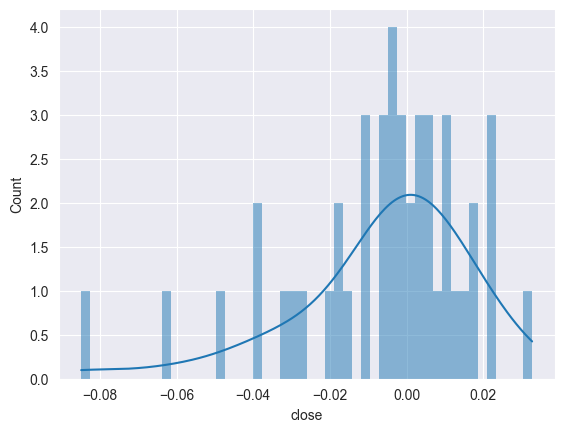

In [139]:
import seaborn as sns

sns.histplot(spx['close'].pct_change(5).shift(-5).loc[fed_up_date], edgecolor = 'none', kde = True, bins = 50)

In [167]:
import numpy as np
import pandas as pd
from scipy.stats import norm

def _weighted_quantile(x: np.ndarray, w: np.ndarray, q: float) -> float:
    order = np.argsort(x)
    xs = x[order]
    ws = w[order]
    cdf = np.cumsum(ws)
    return float(np.interp(q, cdf, xs))

def _posterior_ptsl_empirical(prior_returns: np.ndarray, sigma_roll: float,
                              q_low: float = 0.05, q_high: float = 0.95,
                              like_mean: float = 0.0, std_size : int = 2):
    r = np.asarray(prior_returns, dtype=float)
    r = r[np.isfinite(r)]
    if r.size < 5:
        return None
    if not np.isfinite(sigma_roll) or sigma_roll <= 0:
        return None

    w = norm.pdf(r, loc=like_mean, scale=sigma_roll * std_size)
    sw = w.sum()
    if not np.isfinite(sw) or sw <= 0:
        return None
    w = w / sw

    sl = _weighted_quantile(r, w, q_low)
    pt = _weighted_quantile(r, w, q_high)
    ess = 1.0 / np.sum(w**2)
    return {
        "SL_ret": float(sl),
        "PT_ret": float(pt),
        "ESS": float(ess)
    }

def _get_vertical_barrier_by_bars(close_index: pd.DatetimeIndex, t0: pd.Timestamp, vb_bars: int) -> pd.Timestamp:
    """
    close 인덱스 기준으로 t0 이후 vb_bars번째 bar를 vertical barrier로 지정.
    """
    if vb_bars <= 0:
        raise ValueError("vb_bars must be > 0")

    pos0 = close_index.searchsorted(t0)
    if pos0 >= len(close_index):
        return pd.NaT

    pos1 = pos0 + vb_bars
    if pos1 >= len(close_index):
        return pd.NaT

    return close_index[pos1]

def triple_barrier_labeling_bayes_with_vertical_barrier(
    close: pd.Series,                 # price series (DatetimeIndex)
    events: pd.DataFrame,             # index=event_time, columns=['event_type'] (롱만 가정)
    rolling_std: pd.Series,           # volatility series (DatetimeIndex) - 반드시 과거정보만 반영되게 shift(1) 권장
    vb_bars: int,                     # vertical barrier horizon (bars)
    like_std_size : int = 2,
    q_low: float = 0.05,
    q_high: float = 0.95,
    min_prior_n: int = 30,
    min_ess: float = 10.0,
    fallback: str = "quantile",       # 'quantile' or 'skip'
):
    """
    기능:
    - vertical barrier t1을 vb_bars로 내부에서 생성
    - prior(after_ret)도 동일 vb_bars로 계산
    - 미래 누수 방지:
        prior 표본은 (event_time < t0) AND (event_time의 t1 <= t0) 조건을 만족해야 함
    - 롱(+1)만 가정
    """

    if not isinstance(close.index, pd.DatetimeIndex):
        raise TypeError("close는 DatetimeIndex여야 합니다.")
    close = close.sort_index()
    idx = close.index

    ev = events.copy()
    if not isinstance(ev.index, pd.DatetimeIndex):
        raise TypeError("events index는 DatetimeIndex(event_time)여야 합니다.")
    if "event_type" not in ev.columns:
        raise ValueError("events는 'event_type' 컬럼이 필요합니다.")
    ev = ev.sort_index()

    rolling_std = rolling_std.sort_index()

    # 1) 모든 이벤트에 대해 vertical barrier t1 계산
    ev["t1"] = [
        _get_vertical_barrier_by_bars(idx, t0, vb_bars) for t0 in ev.index
    ]

    # 2) prior용: 각 이벤트의 after_ret(동일 vb_bars) 사전 계산
    #    after_ret은 close[t1]/close[t0]-1 (t0, t1 모두 close 인덱스 기준)
    #    t0가 close에 없으면 t0 이후 첫 거래일로 정렬
    hist_rows = []
    for t0, row in ev.iterrows():
        t1 = row["t1"]
        if pd.isna(t1):
            continue

        pos0 = idx.searchsorted(t0)
        if pos0 >= len(idx):
            continue
        t0a = idx[pos0]
        if t0a >= t1:
            continue

        px0 = float(close.loc[t0a])
        px1 = float(close.loc[t1])
        after_ret = px1 / px0 - 1.0

        hist_rows.append((t0a, t1, row["event_type"], after_ret))

    hist = pd.DataFrame(hist_rows, columns=["event_time", "t1", "event_type", "after_ret"]).sort_values("event_time")

    # 3) 이벤트별로 (t0 시점) posterior PT/SL 계산 + triple barrier 라벨링
    out_rows = []
    for t0, row in ev.iterrows():
        etype = row["event_type"]
        t1 = row["t1"]
        if pd.isna(t1):
            continue

        # t0 정렬(이벤트 시점이 인덱스에 없으면 이후 첫 거래일)
        pos0 = idx.searchsorted(t0)
        if pos0 >= len(idx):
            continue
        t0a = idx[pos0]
        if t0a >= t1:
            continue

        # --- PRIOR: event_time < t0a AND t1 <= t0a (이미 완결된 과거 이벤트만) ---
        prior = hist.loc[
            (hist["event_type"] == etype) &
            (hist["event_time"] < t0a) &
            (hist["t1"] <= t0a),
            "after_ret"
        ].to_numpy()

        prior = prior[np.isfinite(prior)]
        prior_n = int(prior.size)

        if prior_n < min_prior_n:
            if fallback == "skip":
                continue
            if fallback == "quantile" and prior_n >= 5:
                sl_ret = float(np.quantile(prior, q_low))
                pt_ret = float(np.quantile(prior, q_high))
                ess = np.nan
            else:
                continue
        else:
            sigma_slice = rolling_std.loc[:t0a]
            if sigma_slice.empty:
                continue
            sig = float(sigma_slice.iloc[-1])
            ptsl = _posterior_ptsl_empirical(
                prior, sig,
                q_low=q_low,
                q_high=q_high,
                like_mean=0.0,
                std_size=like_std_size
            )
            if ptsl is None:
                continue
            sl_ret = ptsl["SL_ret"]
            pt_ret = ptsl["PT_ret"]
            ess = ptsl["ESS"]
            # ESS 너무 낮으면 원하면 여기서 continue 처리 가능
            if np.isfinite(ess) and ess < min_ess:
                pass

        # --- Triple barrier (롱) ---
        px0 = float(close.loc[t0a])
        path = close.loc[t0a:t1]
        if path.empty:
            continue

        pt_price = px0 * (1.0 + pt_ret)
        sl_price = px0 * (1.0 + sl_ret)

        hit_pt = path >= pt_price
        hit_sl = path <= sl_price

        t_pt = hit_pt.idxmax() if hit_pt.any() else pd.NaT
        t_sl = hit_sl.idxmax() if hit_sl.any() else pd.NaT

        if pd.isna(t_pt) and pd.isna(t_sl):
            touch_time = t1
            label = 0
        elif pd.isna(t_sl):
            touch_time = t_pt
            label = +1
        elif pd.isna(t_pt):
            touch_time = t_sl
            label = -1
        else:
            touch_time = min(t_pt, t_sl)
            label = +1 if touch_time == t_pt else -1

        px_touch = float(close.loc[touch_time]) if touch_time in close.index else float(path.iloc[-1])
        realized_ret = px_touch / px0 - 1.0

        out_rows.append({
            "t0": t0a,
            "t1": t1,
            "event_type": etype,
            "vb_bars": int(vb_bars),
            "pt_ret": float(pt_ret),
            "sl_ret": float(sl_ret),
            "pt_price": float(pt_price),
            "sl_price": float(sl_price),
            "touch_time": touch_time,
            "label": int(label),
            "ret": float(realized_ret),
            "prior_n": prior_n,
            "ess": float(ess) if np.isfinite(ess) else np.nan,
        })

    return pd.DataFrame(out_rows).set_index("t0").sort_index()


In [168]:
rolling_std = spx['close'].pct_change().ewm(5).std()

In [169]:
fed_up_event = pd.DataFrame(
    'FED_UP',
    index = fed_up_date,
    columns = ['event_type']
)

In [170]:
fed_up_event

,event_type
Release Date,
1995-02-01,FED_UP
1997-03-25,FED_UP
1999-06-30,FED_UP
1999-08-24,FED_UP
1999-11-16,FED_UP
2000-02-02,FED_UP
2000-03-21,FED_UP
2000-05-16,FED_UP
2004-06-30,FED_UP


In [171]:
labeled = triple_barrier_labeling_bayes_with_vertical_barrier(
    close=spx['close'],
    events=fed_up_event,
    rolling_std=rolling_std,
    vb_bars=5,
    q_low=0.05,
    q_high=0.95,
    min_prior_n=3,
    fallback="quantile",
)

In [172]:
labeled

,t1,event_type,vb_bars,pt_ret,sl_ret,pt_price,sl_price,touch_time,label,ret,prior_n,ess
t0,,,,,,,,,,,,
2000-02-02,2000-02-09,FED_UP,5,0.021327,-0.049375,1439.172525,1339.545292,2000-02-09,0,0.002704,5,4.496468
2000-03-21,2000-03-28,FED_UP,5,0.020877,-0.049375,1525.057749,1420.110796,2000-03-23,1,0.022412,6,5.746891
2000-05-16,2000-05-23,FED_UP,5,0.020417,-0.049375,1495.972582,1393.654890,2000-05-23,-1,-0.062884,7,6.385951
2004-06-30,2004-07-08,FED_UP,5,0.014225,-0.027006,1156.976762,1109.943118,2004-07-08,-1,-0.027745,8,3.566497
2004-08-10,2004-08-17,FED_UP,5,0.019732,-0.038665,1100.331956,1037.318857,2004-08-17,0,0.002474,9,6.305516
2004-09-21,2004-09-28,FED_UP,5,0.014154,-0.023826,1145.283799,1102.393748,2004-09-28,0,-0.017037,10,4.838855
2004-11-10,2004-11-17,FED_UP,5,0.015499,-0.025686,1180.933815,1133.039973,2004-11-12,1,0.018282,11,6.349571
2004-12-14,2004-12-21,FED_UP,5,0.016263,-0.023681,1222.950097,1174.882929,2004-12-21,0,0.001704,12,6.790975
2005-02-02,2005-02-09,FED_UP,5,0.016135,-0.020517,1212.441546,1168.709237,2005-02-09,0,-0.001006,13,7.245145
